In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression

### Define Dimensions

* we choose an underdetermined where N << d

In [3]:
N = 5
d = 25

### Define Dataset

* to make sure the data is realizable by a linear model we create the y using a fitter linear regressor.

* the regressor is chosen to have positive coefficients and no intercept to simulate our u^2 model.

In [4]:
x = np.random.normal(size=(N, d))
y_inital = np.zeros((N,))    # this is just a place-hold for the shape of y

In [5]:
reg = LinearRegression().fit(x, y_inital)
reg.coef_ = np.random.random(size=(d,))   # set positive coefficients only

In [6]:
y = reg.predict(x)

### Define Gradient Decent

* $r_n(t) = \mathbf{X}^T \cdot \mathbf{u}^2(t) - y$

* $\dot{\mathbf{u}_i}(t) = - \mathbf{u}_i(t) \sum_n x_{n, i} r_n(t)$

* $L(u) = \frac12 \sum_n r_n(t)^2$

In [7]:
def update(u, x, y, step_size):
    r = np.dot(x, u**2) - y
    grad_u = - np.multiply(np.dot(x.transpose(), r), u)
    u = u + step_size * grad_u
    loss = 0.5 * np.sum(r**2)
    return u, loss

### Define Q

* $q(z) = \frac{z \cdot (ln(z) - 1)}{2}$
* $Q(w) = \sum_{i \in [d]} w_i(0) \cdot q(\frac{w_i}{w_i(0)})$

In [8]:
def q_func(x):
    return 0.5 * x * (np.log(x) - 1)

In [9]:
def Q_func(w, w_0):
    f = 0
    for w_i, w_0_i in zip(w, w_0):
        f += w_0_i * q_func(w_i / w_0_i)
    return f

In [10]:
def solver(x, y, w_0, obj='L1', optim_tol=1e-6):
    
    cons = {'type': 'eq', 'fun': lambda w: np.dot(x, w) - y}

    if obj == 'L1':
        objective = lambda w: np.linalg.norm(w, ord=1)
    elif obj == 'L2':
        objective = lambda w: np.linalg.norm(w, ord=2)
    elif obj == 'Q':
        objective = lambda w: Q_func(w, w_0)
    else:
        raise ValueError('objective not supported.')
    
    sol = minimize(
        fun=objective,
        x0=w_0,
        constraints=cons,
        tol=optim_tol,
        method='SLSQP',
        options={
            'maxiter': 100000,
            'disp': True
        }
    )
    is_failed = (not sol.success)
    if is_failed:
        raise RuntimeError('Minimization Failed.')

    return sol.x

### Find L1 / L2 solutions

In [11]:
u_0 = np.random.normal(size=(d,))
w_0 = u_0**2

In [112]:
w_opt_L1 = solver(x, y, w_0, obj='L1', optim_tol=1e-5)

minimal_L1 = np.linalg.norm(w_opt_L1, ord=1)
minimal_L1

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.051164129100934
            Iterations: 348
            Function evaluations: 9663
            Gradient evaluations: 348


2.051164129100934

In [113]:
loss = 0.5 * np.sum((np.dot(x, w_opt_L1) - y)**2)
loss

6.372766070878544e-24

In [114]:
w_opt_L2 = solver(x, y, w_0, obj='L2', optim_tol=1e-5)

minimal_L2 = np.linalg.norm(w_opt_L2, ord=2)
minimal_L2

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.7357992470277386
            Iterations: 29
            Function evaluations: 793
            Gradient evaluations: 29


0.7357992470277386

In [115]:
loss = 0.5 * np.sum((np.dot(x, w_opt_L2) - y)**2)
loss

9.068341806549786e-21

### Run GD

* check GD solutions at high / low $\alpha$ values where:
* $u_0 \sim{}  N(0, \alpha)$ 

In [67]:
def run_GD(u_0, n_epochs, step_size): 
    u = np.array(u_0)

    for epoch in range(n_epochs):
        u, loss = update(u, x, y, step_size)
        
    L1 = np.linalg.norm(u**2, ord=1)
    L2 = np.linalg.norm(u**2, ord=2)
    return L1, L2, u, loss

In [77]:
u_0 = np.random.normal(size=(d,), loc=0, scale=1e-6)  

L1, L2, u, loss = run_GD(u_0=u_0, n_epochs=10000, step_size=0.01)
L1, L2, loss

(2.0834237380365046, 1.1942288473258653, 9.760497402357848e-29)

In [73]:
u_0 = np.random.normal(size=(d,), loc=0, scale=100)  

L1, L2, u, loss = run_GD(u_0=u_0, n_epochs=10000, step_size=0.001/100**2)
L1, L2, loss

(149734.20268263438, 45806.396725771796, 2.4652990650068086e-19)

In [109]:
L1_GD = []
L2_GD = []
loss_GD = []

alpha_range = [1e-6, 1e-3, 1e-2, 1e-1, 0.5, 1, 2.5, 10, 1e2]

for alpha in alpha_range:
    u_0 = np.random.normal(size=(d,), loc=0, scale=alpha)   
    w_0 = np.array(u_0**2)
    
    L1, L2, u, loss = run_GD(u_0=u_0, n_epochs=10000, step_size=0.001/max(0.1, alpha**2))
    L1_GD.append(L1)
    L2_GD.append(L2)
    loss_GD.append(loss)

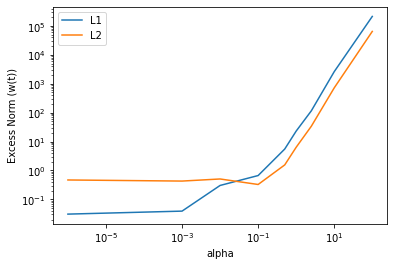

In [116]:
excess_L1 = [l1 - minimal_L1 for l1 in L1_GD]
excess_L2 = [l2 - minimal_L2 for l2 in L2_GD]

plot(alpha_range, excess_L1)
plot(alpha_range, excess_L2)
yscale('log')
xscale('log')
xlabel('alpha')
ylabel('Excess Norm (w(t))')
legend(['L1', 'L2'])

### Compare Q to GD

In [103]:
L1_GD = []
L2_GD = []
loss_GD = []
L1_Q = []
L2_Q = []
loss_Q = []

alpha_range = [1e-2, 1e-1, 0.5, 1, 10, 1e2]

for alpha in alpha_range:
    u_0 = np.random.normal(size=(d,), loc=0, scale=alpha)   
    w_0 = np.array(u_0**2)

    w_opt_Q = solver(x, y, w_0, obj='Q', optim_tol=1e-3)
    
    loss_Q.append(0.5 * np.sum((np.dot(x, w_opt_Q) - y)**2))
    L1_Q.append(np.linalg.norm(w_opt_Q, ord=1))
    L2_Q.append(np.linalg.norm(w_opt_Q, ord=2))
    
    L1, L2, u, loss = run_GD(u_0=u_0, n_epochs=10000, step_size=0.001/max(0.01, alpha**2))
    L1_GD.append(L1)
    L2_GD.append(L2)
    loss_GD.append(loss)

/Users/shaharazulay/anaconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8.081311263399687
            Iterations: 81
            Function evaluations: 2502
            Gradient evaluations: 81
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.841784474526591
            Iterations: 60
            Function evaluations: 1736
            Gradient evaluations: 60
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3.8158484796333774
            Iterations: 16
            Function evaluations: 450
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -10.591730161728332
            Iterations: 21
            Function evaluations: 587
            Gradient evaluations: 21
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -675.8231090713889
            Iterations: 131
            

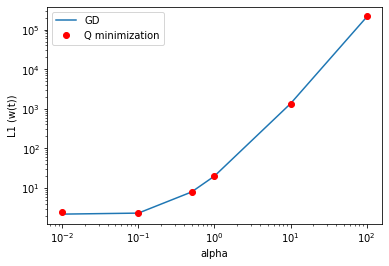

In [104]:
plot(alpha_range, L1_GD);
plot(alpha_range, L1_Q, 'ro');
yscale('log')
xscale('log')
xlabel('alpha')
ylabel('L1 (w(t))')
legend(['GD', 'Q minimization'])

In [105]:
loss_GD

[2.427634694900111e-31,
 4.3140830754274083e-32,
 8.887665951561553e-29,
 1.4608841148078053e-27,
 1.1005734595959579e-14,
 1.5286715390032047e-19]

In [106]:
loss_Q

[3.0371261470775986e-22,
 1.4030791377772943e-18,
 2.858997110665014e-19,
 3.0299183566037302e-18,
 8.413060408637857e-15,
 1.0848810147689512e-07]